<a href="https://colab.research.google.com/github/vaidande/Car-Damage-Detection-Detectron2/blob/main/Car_Damage_Detection_Detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
!nvidia-smi

Tue Jun 29 07:14:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
!pip install pyyaml==5.1
# workaround: install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9 (issue: https://github.com/facebookresearch/detectron2/issues/3158)
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install detectron2 that matches pytorch 1.8
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 763.5MB 23kB/s 
     |████████████████████████████████| 17.3MB 190kB/s 
ERROR: torchtext 0.10.0 has requirement torch==1.9.0, but you'll have torch 1.8.0+cu101 which is incompatible.
  Found existing installation: torch 1.8.1+cu111
    Uninstalling torch-1.8.1+cu111:
      Successfully uninstalled torch-1.8.1+cu111
  Found existing installation: torchvision 0.9.1+cu111
    Uninstalling torchvision-0.9.1+cu111:
      Successfully uninstalled torchvision-0.9.1+cu111


Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html


In [1]:
# check pytorch installation: 
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.8")   # please manually install torch 1.8 if Colab changes its default version

1.8.0+cu101 True


In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2, os, json, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [3]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("train", {}, "/content/gdrive/MyDrive/car_damage/train/COCO_mul_train_annos.json", "/content/gdrive/MyDrive/car_damage/train")
register_coco_instances("valid", {}, "/content/gdrive/MyDrive/car_damage/val/COCO_mul_val_annos.json", "/content/gdrive/MyDrive/car_damage/val")

In [4]:
train_metadata = MetadataCatalog.get("train")
dataset_dicts = DatasetCatalog.get("train")

[06/29 07:42:04 d2.data.datasets.coco]: Loaded 59 images in COCO format from /content/gdrive/MyDrive/car_damage/train/COCO_mul_train_annos.json


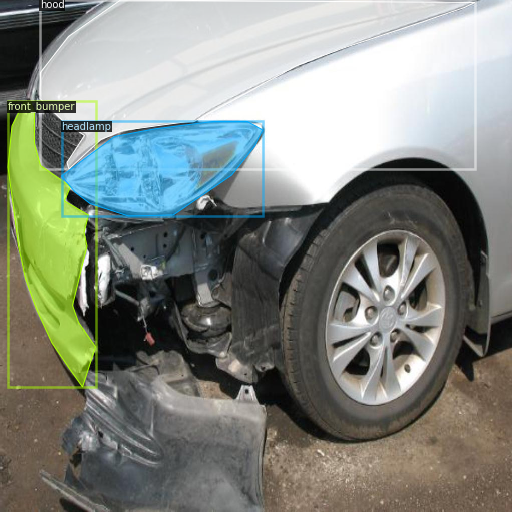

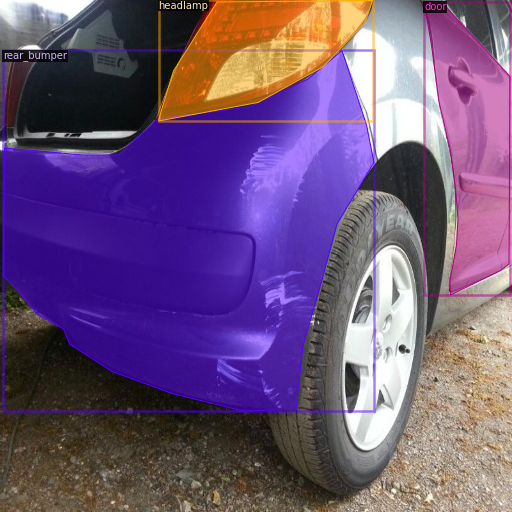

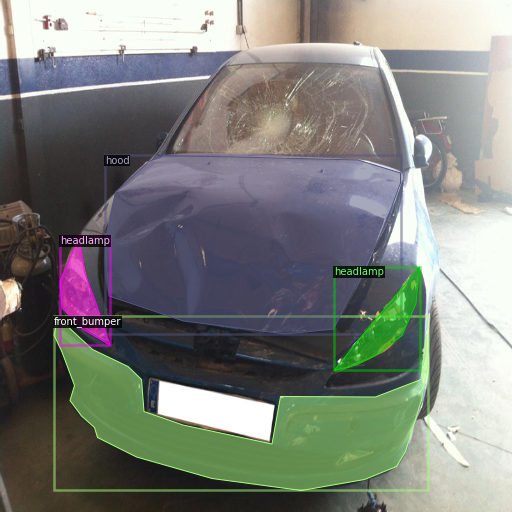

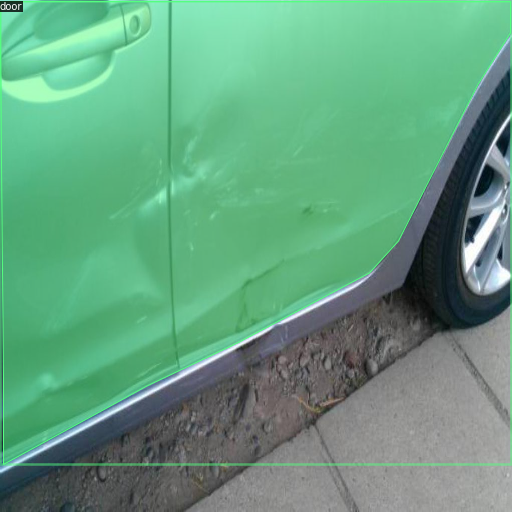

In [5]:
import random

for d in random.sample(dataset_dicts, 4):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [5]:
cd /content

/content


In [6]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo

fatal: destination path 'detectron2_repo' already exists and is not an empty directory.


In [78]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file("/content/detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("train")
cfg.DATASETS.TEST = ("valid")   
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl" 
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025
cfg.SOLVER.MAX_ITER = 4000    
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5

#Comment below lines if you are not training
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

In [79]:
cfg.MODEL.WEIGHTS = os.path.join("/content/gdrive/MyDrive/car_damage/model/output/model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   
cfg.DATASETS.TEST = ("valid")
predictor = DefaultPredictor(cfg)

[06/29 10:47:03 fvcore.common.checkpoint]: Loading checkpoint from /content/gdrive/MyDrive/car_damage/model/output/model_final.pth


[06/29 11:04:35 d2.data.datasets.coco]: Loaded 11 images in COCO format from /content/gdrive/MyDrive/car_damage/val/COCO_mul_val_annos.json


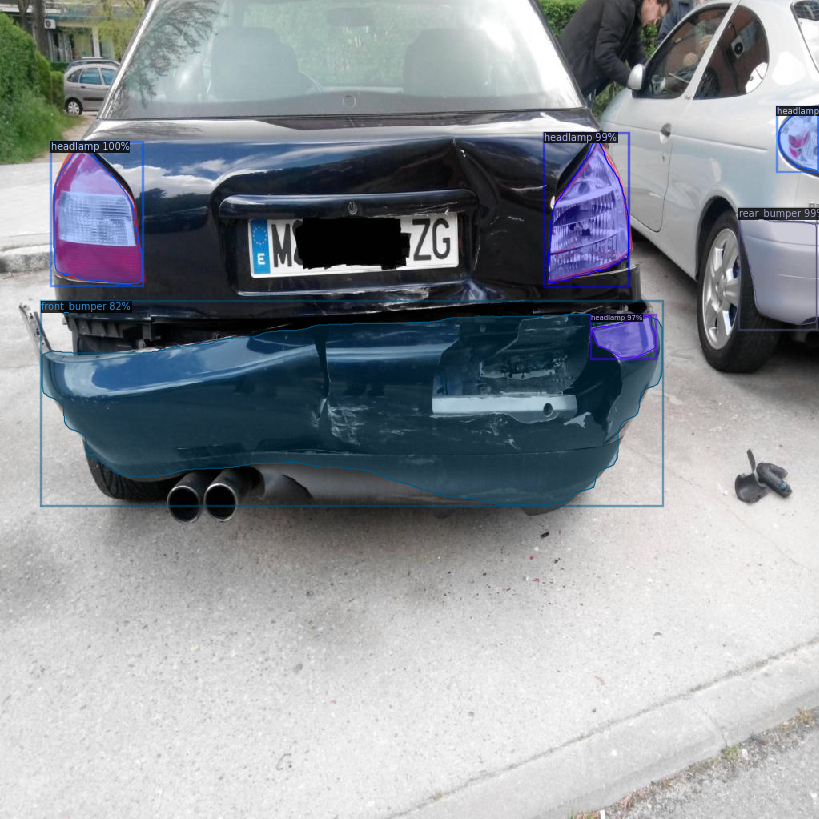

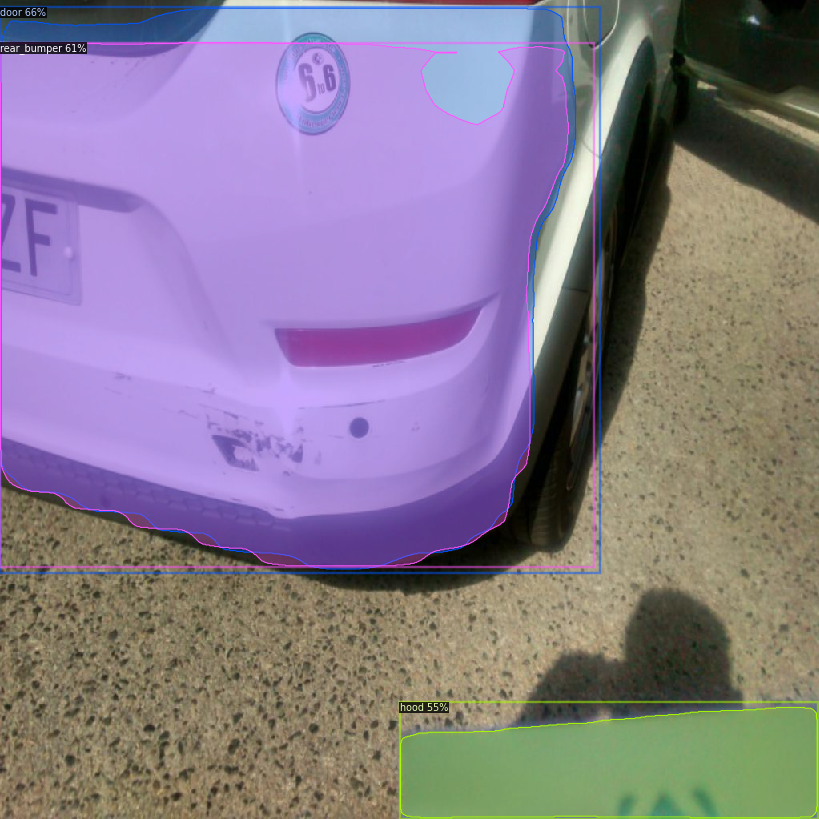

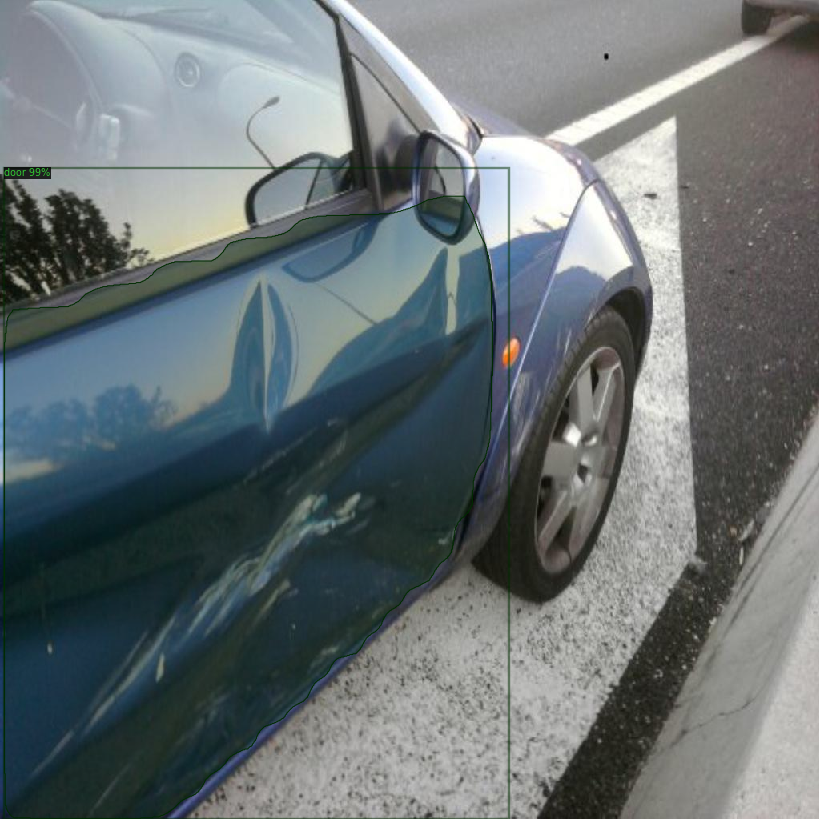

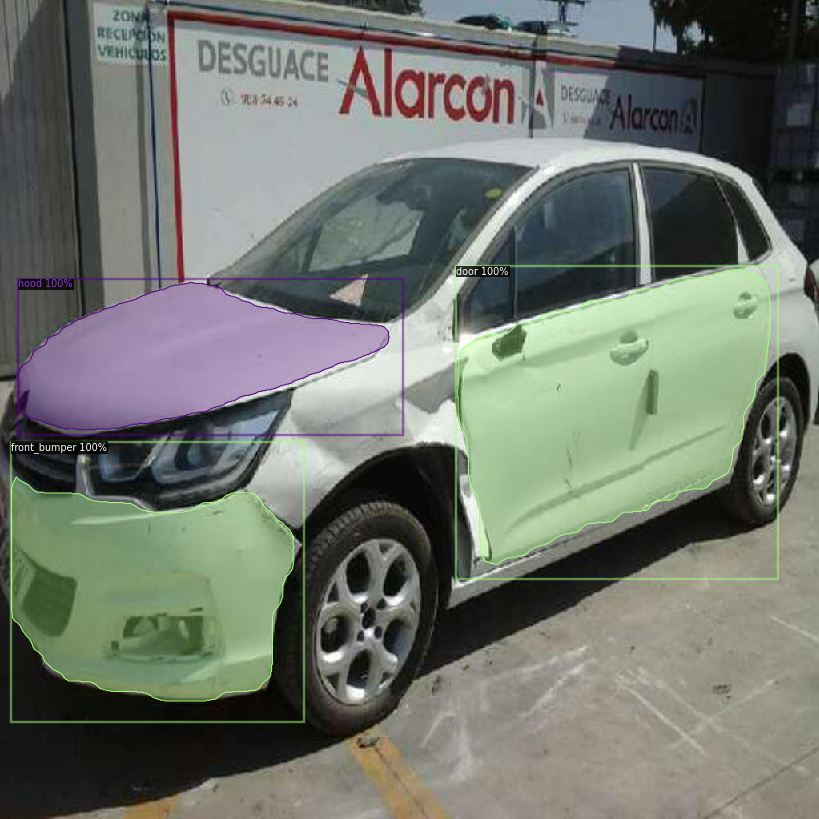

In [83]:
from detectron2.utils.visualizer import ColorMode

dataset_dicts = DatasetCatalog.get("valid")
for d in random.sample(dataset_dicts, 4):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=train_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [82]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
# import some common libraries
import numpy as np
import tqdm
import cv2
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.video_visualizer import VideoVisualizer
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.data import MetadataCatalog
import time


v = VideoVisualizer(metadata=train_metadata,instance_mode=ColorMode.IMAGE_BW)

# Extract video properties
video = cv2.VideoCapture('/content/detectron2_repo/demo/oye5.mp4')
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
frames_per_second = video.get(cv2.CAP_PROP_FPS)
num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

# Initialize video writer
video_writer = cv2.VideoWriter('out.mp4', fourcc=cv2.VideoWriter_fourcc(*"mp4v"), fps=float(frames_per_second), frameSize=(width, height), isColor=True)

def runOnVideo(video, maxFrames):
    """ Runs the predictor on every frame in the video (unless maxFrames is given),
    and returns the frame with the predictions drawn.
    """

    readFrames = 0
    while True:
        hasFrame, frame = video.read()
        if not hasFrame:
            break

        # Get prediction results for this frame
        outputs = predictor(frame)

        # Make sure the frame is colored
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        # Draw a visualization of the predictions using the video visualizer
        visualization = v.draw_instance_predictions(frame, outputs["instances"].to("cpu"))

        # Convert Matplotlib RGB format to OpenCV BGR format
        visualization = cv2.cvtColor(visualization.get_image(), cv2.COLOR_RGB2BGR)

        yield visualization

        readFrames += 1
        if readFrames > maxFrames:
            break

# Create a cut-off for debugging
num_frames = 120

# Enumerate the frames of the video
for visualization in tqdm.tqdm(runOnVideo(video, num_frames), total=num_frames):

    # Write test image
    cv2.imwrite('POSE detectron2.png', visualization)

    # Write to video file
    video_writer.write(visualization)

# Release resources
video.release()
video_writer.release()
cv2.destroyAllWindows()



  0%|          | 0/120 [00:00<?, ?it/s]

  1%|          | 1/120 [00:00<00:33,  3.58it/s]

  2%|▏         | 2/120 [00:00<00:32,  3.67it/s]

  2%|▎         | 3/120 [00:00<00:29,  3.92it/s]

  3%|▎         | 4/120 [00:00<00:28,  4.11it/s]

  4%|▍         | 5/120 [00:01<00:27,  4.23it/s]

  5%|▌         | 6/120 [00:01<00:26,  4.34it/s]

  6%|▌         | 7/120 [00:01<00:25,  4.46it/s]

  7%|▋         | 8/120 [00:01<00:24,  4.56it/s]

  8%|▊         | 9/120 [00:02<00:24,  4.53it/s]

  8%|▊         | 10/120 [00:02<00:24,  4.56it/s]

  9%|▉         | 11/120 [00:02<00:23,  4.65it/s]

 10%|█         | 12/120 [00:02<00:22,  4.75it/s]

 11%|█         | 13/120 [00:02<00:22,  4.80it/s]

 12%|█▏        | 14/120 [00:03<00:22,  4.80it/s]

 12%|█▎        | 15/120 [00:03<00:21,  4.82it/s]

 13%|█▎        | 16/120 [00:03<00:21,  4.85it/s]

 14%|█▍        | 17/120 [00:03<00:21,  4.84it/s]

 15%|█▌        | 18/120 [00:03<00:21,  4.84it/s]

 16%|█▌        | 19/120 [00:04<00:21,  4.77it/s]

 17%|█▋        |